In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from segmenter import *
from IPython.core.debugger import set_trace
torch.cuda.is_available(), torch.backends.cudnn.enabled

(True, True)

# Data Paths and Loading

In [10]:
PATH = Path('/home/sean/hpc-home/skin_cancer/ISIC')

%ls $PATH

classification/                            models/
download*                                  Part3_train_gt.csv*
download.1*                                Part3_val_gt.csv*
ISIC-2017_Training_Data/                   tmp/
ISIC-2017_Training_Part1_GroundTruth/      train.csv*
ISIC-2017_Training_Part1_GroundTruth.zip*  valset_download*
ISIC-2017_Validation_Data/                 valset_gt_download*
ISIC-2017_Validation_Part1_GroundTruth/


In [11]:
xtrn_path = PATH / 'ISIC-2017_Training_Data'
ytrn_path = PATH / 'ISIC-2017_Training_Part1_GroundTruth'

xval_path = PATH / 'ISIC-2017_Validation_Data'
yval_path = PATH / 'ISIC-2017_Validation_Part1_GroundTruth'

xtrn_path.exists(), ytrn_path.exists(), xval_path.exists(), ytrn_path.exists()

(True, True, True, True)

In [12]:
j='.jpg'
p='.png'

trn_x = g_fns(xtrn_path, j)
val_x = g_fns(xval_path, j)

trn_y = g_fns(ytrn_path, p)
val_y = g_fns(yval_path, p)

Can incrementally increase image size (sz) to get better performance, try not to exceed the sizes in the histograms below

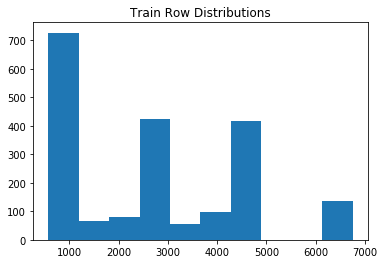

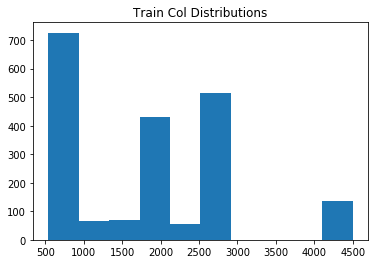

In [15]:
im_hist(trn_x, n='Train')

# Data Iterator

In [16]:
sz = 128
bs = 64
nw = 4
arch = resnet34

In [17]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomDihedral(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]

In [18]:
tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
mdata = ImageData(PATH, datasets, bs, num_workers=nw, classes=None)
denorm = mdata.trn_ds.denorm

In [19]:
x,y = next(iter(mdata.trn_dl))
x = denorm(x)
x.shape,y.shape, np.unique(y)

((64, 128, 128, 3), torch.Size([64, 128, 128]), array([0., 1.], dtype=float32))

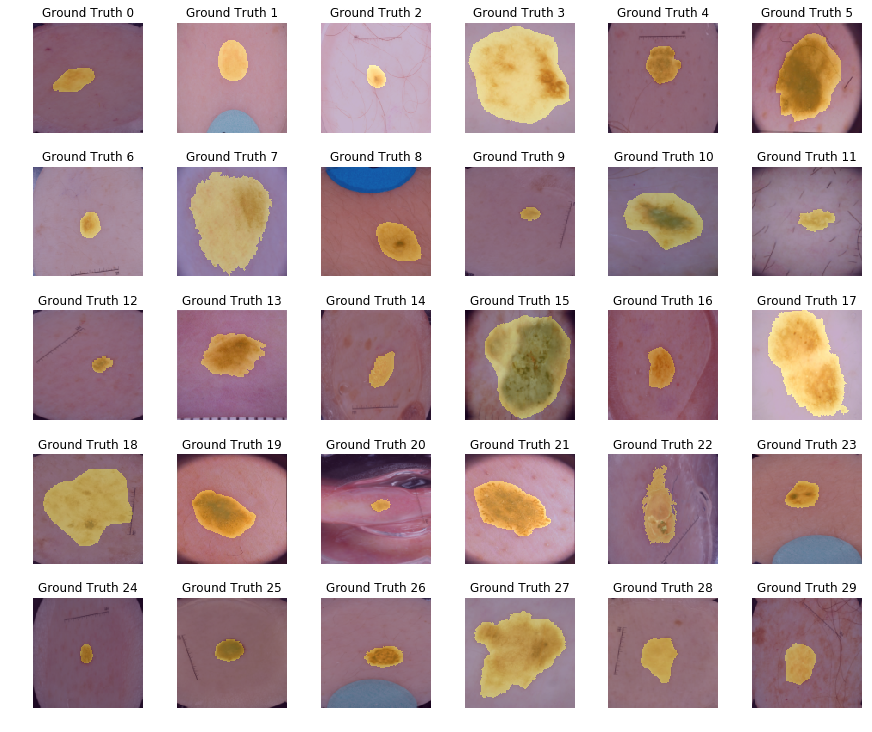

In [20]:
plot_data(x, y)

# Setup Network

Place/cut resnet into groups for unet to connect to.

In [21]:
cut, lr_cut = model_meta[arch]

In [22]:
# core CNN
m_base = get_base(arch, cut)
unet = to_gpu(Unet34(m_base))
models = UnetModel(unet, lr_cut)

In [23]:
# Setup for training
learn = ConvLearner(mdata, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [26]:
# run if you want some idea on model construction
learn.summary(), [o.features.size() for o in unet.sfs]

# Train Network

In [22]:
def plot_training():
    plot_loss(learn.sched.losses, learn.sched.val_losses,
              list(zip(*learn.sched.rec_metrics))[0], learn.sched.epoch, learn.sched.epochs)

This is where the magic happens

In [17]:
learn.freeze_to(1) # freeze all but the last 'group' of the model

 94%|█████████▍| 30/32 [03:52<00:15,  7.76s/it, loss=1.38] 

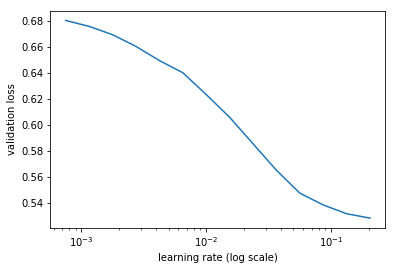

In [18]:
learn.lr_find()
learn.sched.plot()

In [19]:
# initial hyperparams (not set by me)
lr = 4e-2
wd=1e-7
lrs = np.array([lr/100, lr/10, lr])

In [20]:
learn.fit(lr,1,wds=wd,cycle_len=8,use_clr=(5,8))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.20386    5.975144   0.466106   0.357401  
    1      0.147406   0.194409   0.930852   0.77837        
    2      0.125027   0.170262   0.936603   0.804969       
    3      0.113016   0.145012   0.94552    0.820089       
    4      0.10574    0.156919   0.93937    0.808984       
    5      0.097959   0.138015   0.945972   0.833802        
    6      0.093652   0.134588   0.951059   0.840999        
    7      0.089783   0.129867   0.948807   0.844219        


[array([0.12987]), 0.9488073754310608, 0.8442185278955443]

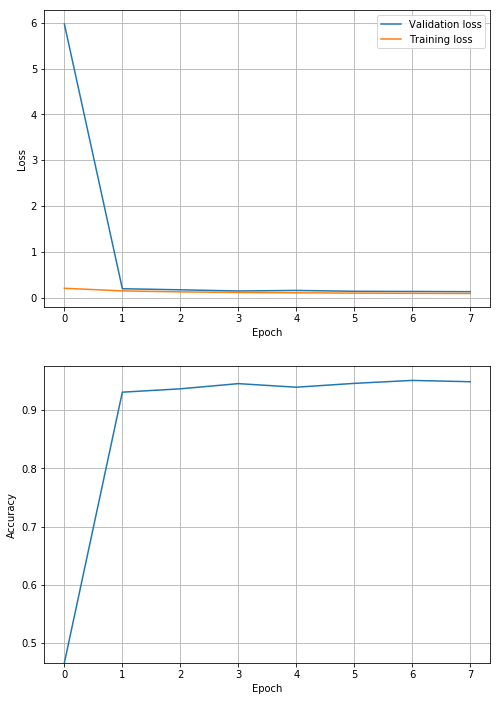

In [23]:
plot_training()

In [24]:
learn.save('128unet2')

In [25]:
learn.load('128unet2')

Visualise performance thus far...

In [26]:
x,y = next(iter(mdata.val_dl))
py = to_np(learn.model(V(x)))
x_den = denorm(x)

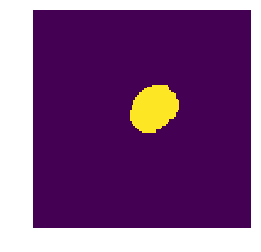

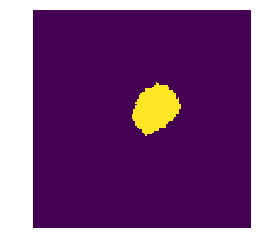

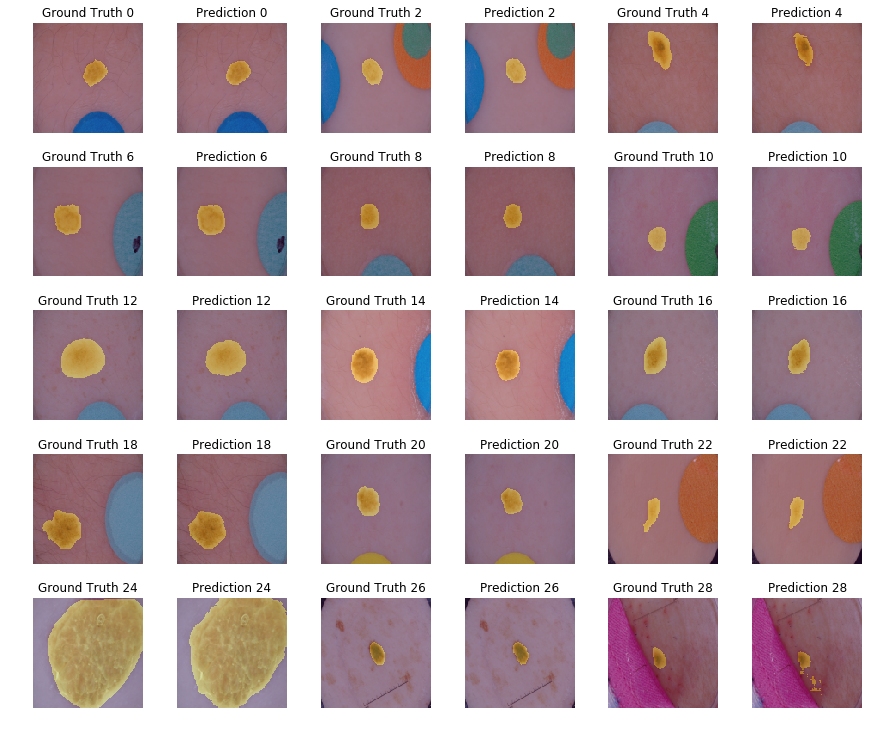

In [25]:
show_img(py[0]>0); show_img(y[0]);
plot_preds(x_den, y, py)

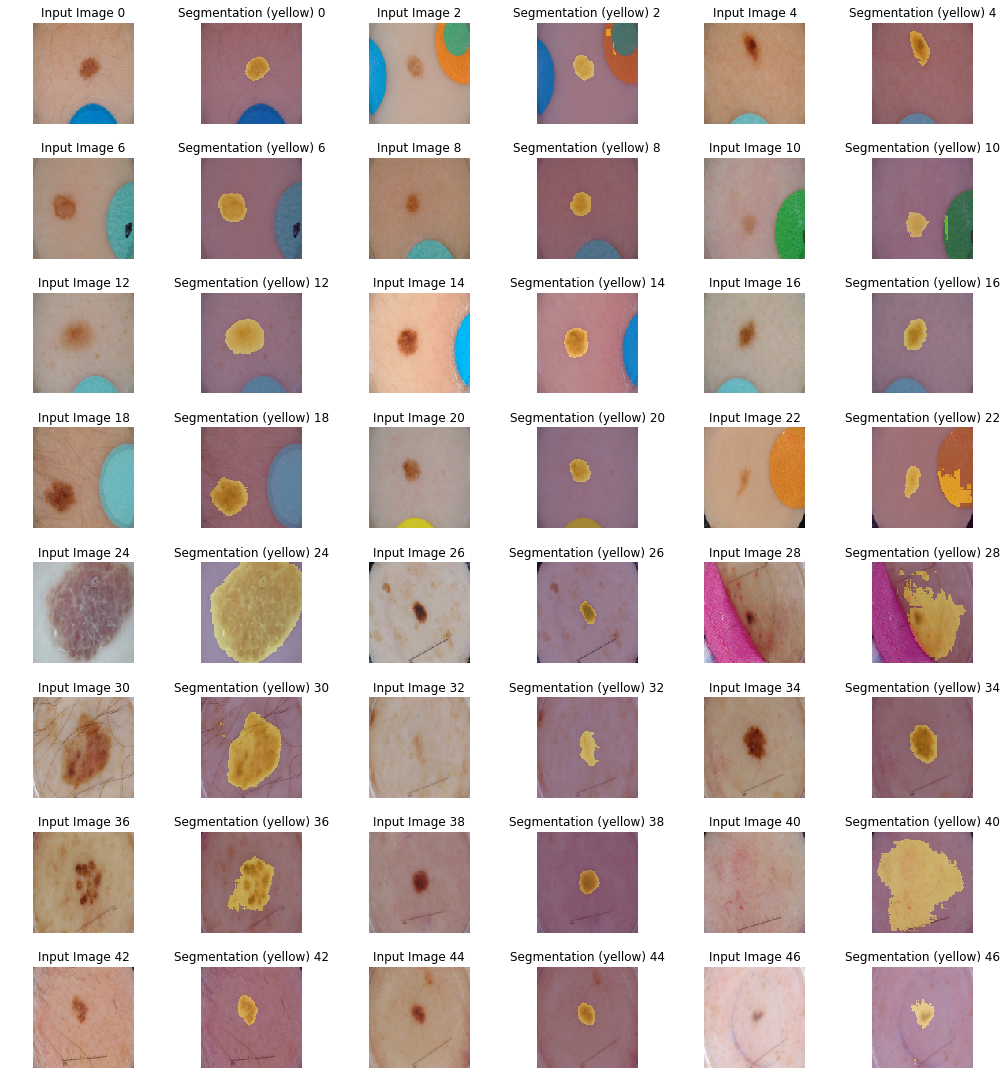

In [29]:
from segmenter import *
plot_img_n_preds(x_den, py > 0, splots=(8,6), fsize=(14,15))

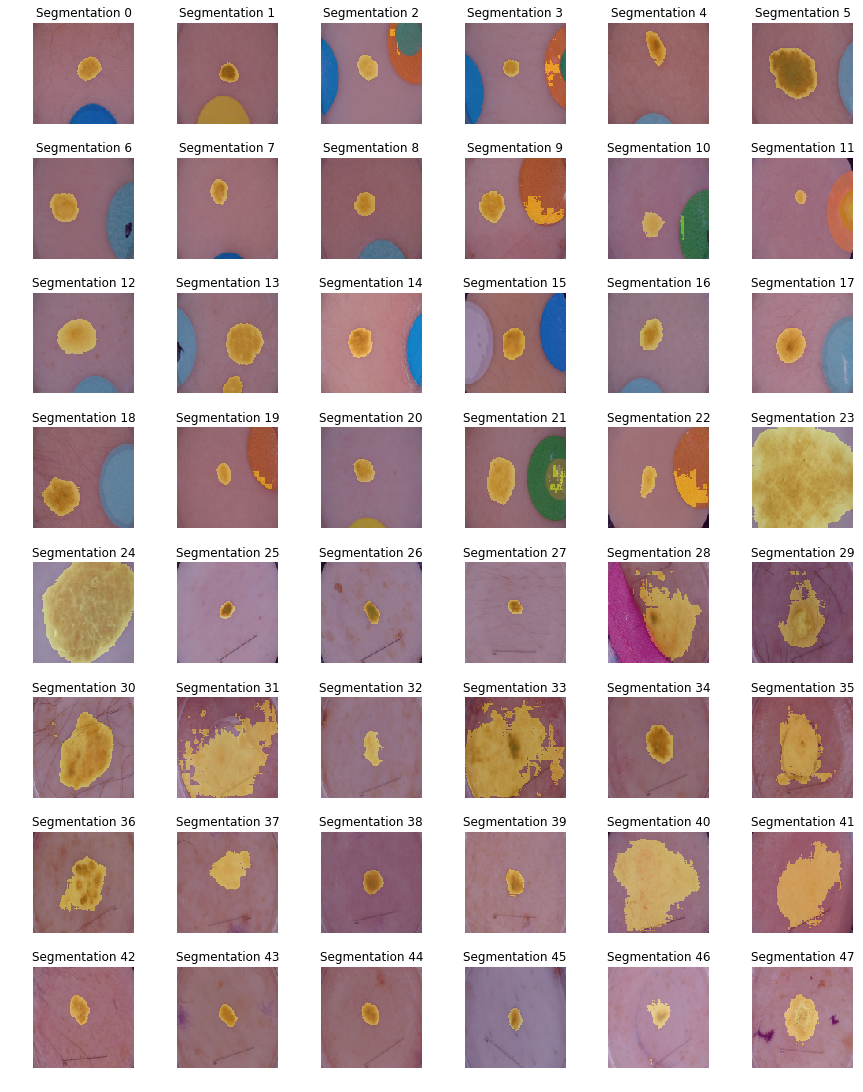

In [53]:
# from segmenter import *
plot_data(x_den, py > 0, title='Segmentation', splots=(8,6), fsize=(12,15))
# py.shape, (py[1] > 0).shape, y[1].shape, type(py), type(y), np.unique(to_np(y))

Do some more training. Optional, but likely to improve performance.

In [ ]:
learn.unfreeze()
# learn.bn_freeze(True) # freeze bn params, good for similar datasets

In [ ]:
# This will train for about 20 epochs
learn.fit(lrs/4, 1, wds=wd, cycle_len=20,use_clr=(20,10))

In [ ]:
# Run if you want to see the learning rate schedule (run after a .fit call)
learn.sched.plot_lr()

Repeat, let's look at the losses and then visualise some results

In [ ]:
plot_training()

In [ ]:
x,y = next(iter(mdata.val_dl))
py = to_np(learn.model(V(x)))
x_den = denorm(x)

show_img(py[0]>0); show_img(y[0]);
plot_preds(x_den, y, py)